In [ ]:
import xarray as xr
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
import metpy.calc as mpcalc
import metpy.constants as mpconst

from skimage.measure import label, regionprops, perimeter

import math
import sys
#sys.path.append('../../util')
#from curvature import *


# Generate Pickles if needed

In [2]:
for TTT in np.arange(296,305):
    i = TTT-296 #index
    
    #Open constants file
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
    const = xr.open_mfdataset(path+'output_3D/lfff00000000c.nc', combine='by_coords', )

    #Load 2D files
    try:
        d2D = pickle.load( open('pickles/output_'+str(TTT)+'.pkl', "rb" ) )
    except:
        path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
        d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )

        with open('pickles/output_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(d2D, pickle_file)
            
    #Load 3D files
    try:
        d3D = pickle.load( open('pickles/output_3D_'+str(TTT)+'.pkl', "rb" ) )
    except:
        path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
        d3D = xr.open_mfdataset(path+'output_3D/lfff????0000.nc', combine='by_coords', )
   
        with open('pickles/output_3D_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(d3D, pickle_file)

# CVW PDF

In [4]:
def calc_BLW(fld, dx = 3.3e3, perc=88):
    ### Input:Column Water Vapour (x, y)
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    ### Parameters: dx grid spacing of input field, perc 
    
    binary = np.where(fld > np.percentile(fld, perc, interpolation='linear',  axis=(0,1))[np.newaxis, np.newaxis], 1, 0)
    A_tot = np.sum(binary)*(dx**2) #Area equals to the number of grid points times the gridspacing
    
    BLW = 2*np.sqrt(np.pi*A_tot)/(dx*perimeter(binary))
    
    return BLW

In [5]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [16]:
hist = np.zeros((9, 100))
edges = np.zeros((9,101))
mean_TQV = np.zeros(9)
mean_P = np.zeros(9)
BLW = np.zeros(9)
perc = np.zeros(9)
median=np.zeros(9)

for TTT in np.arange(296,305):
    i = TTT-296 #index
    
    d2D = pickle.load( open('pickles/output_'+str(TTT)+'.pkl', "rb" ) )   
    tqv = d2D.TQV.isel(time=slice(24*85, None))
    
    #Compute mean histogram
    h = np.zeros((tqv.time.size, 100))
    e = np.zeros((tqv.time.size, 101))
    for t in range(tqv.time.size):
        density, e[t,:] = np.histogram(tqv.isel(time=t).values, density = True, bins = np.arange(0,131.3,1.3))
        h[t,:]  = density / density.sum()
           
    hist[i,:] = np.mean(h,axis=0)
    edges[i,:] = np.mean(e,axis=0)

    print(TTT, np.sum(hist[i,:]))
        
    #Compute BLW
    for t in range(tqv.time.size):
        BLW[i] = np.mean(calc_BLW(tqv.isel(time=t).values))
    
    #Compute other indices
    mean_TQV[i] = tqv.mean()
    perc[i]=np.percentile(tqv, 88)
    median[i]=np.percentile(tqv, 50)

    
#Save data
with open('pickles/dT_hist.pkl', 'wb') as pickle_file:
    pickle.dump(hist, pickle_file)
        
with open('pickles/dT_edges.pkl', 'wb') as pickle_file:
    pickle.dump(edges, pickle_file)
        
with open('pickles/dT_BLW.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
        
with open('pickles/dT_mean_TQV.pkl', 'wb') as pickle_file:
    pickle.dump(mean_TQV, pickle_file)
        
with open('pickles/dT_p88.pkl', 'wb') as pickle_file:
    pickle.dump(perc, pickle_file)
    
with open('pickles/dT_median.pkl', 'wb') as pickle_file:
    pickle.dump(median, pickle_file)

296 0.9999999999999998
297 1.0000000000000002
298 0.9999999999999999
299 0.9999999999999999
300 1.0
301 0.9999999999999999
302 1.0
303 1.0
304 1.0


In [38]:
hist = pickle.load( open( 'pickles/dT_hist.pkl', "rb" ) )
edges = pickle.load( open( 'pickles/dT_edges.pkl', "rb" ) )
BLW = pickle.load( open( 'pickles/dT_BLW.pkl', "rb" ) )
mean_TQV = pickle.load( open( 'pickles/dT_mean_TQV.pkl', "rb" ) )                            
perc = pickle.load( open( 'pickles/dT_p88.pkl', "rb" ) )
median = pickle.load( open( 'pickles/dT_median.pkl', "rb" ) )

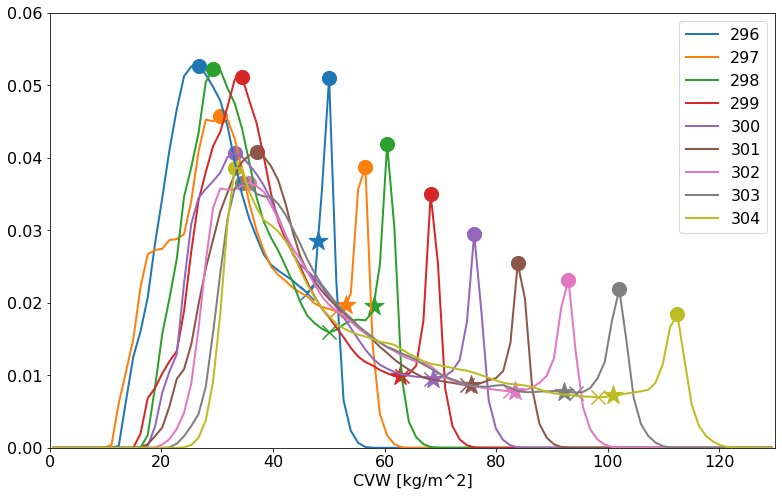

In [36]:
lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(13,8))
plt.rcParams.update({'font.size': 16})


for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=3)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=3)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:], order=3)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(0,130)
plt.ylim(0, 0.06)
plt.xlabel('CVW [kg/m^2]')
plt.legend()

plt.savefig('dSST_CWV_PDF.pdf')

88th percentile 0.09162701004582835
Anti Mode 0.09974846970922602
Dry Mode 0.0281079952043252
Moist Mode 0.10021319448070519
Mean 0.07725509110198864


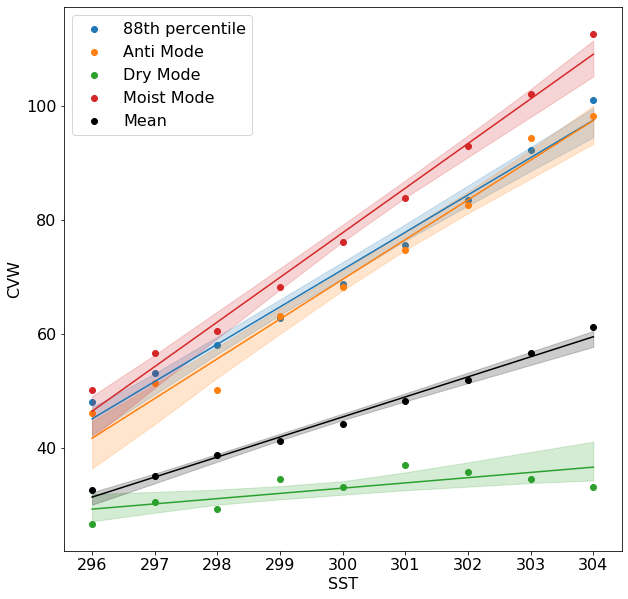

In [40]:
fig=plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
x = np.arange(296,305)
y = np.zeros((100,9))
m = np.zeros((100))

plt.scatter(x, perc, label='88th percentile')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], perc[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0))
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())
print('88th percentile',np.mean(m)/np.mean(perc[:]))


plt.scatter(x, lmin, label='Anti Mode')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], lmin[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0))
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())
print('Anti Mode',np.mean(m)/np.mean(lmin[:]))


plt.scatter(x, lmax[:,0], label='Dry Mode')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], lmax[ind,0], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0))
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())

print('Dry Mode',np.mean(m)/np.mean(lmax[:,0]))




plt.scatter(x, lmax[:,1], label='Moist Mode')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], lmax[ind,1], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0))
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())
print('Moist Mode',np.mean(m)/np.mean(lmax[:,1]))




plt.scatter(x, mean_TQV, label='Mean', color='k')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], mean_TQV[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0), color='k')
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())
print('Mean',np.mean(m)/np.mean(mean_TQV[:]))


plt.ylabel('CVW')
plt.xlabel('SST')

plt.legend()


plt.savefig('dSST_mode_sclaing.pdf')

# Scaling of BLW

In [41]:
def calc_BLW_rel(fld, dx = 3.3e3, th=40):
    ### Input:Column Water Vapour (x, y)
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    ### Parameters: dx grid spacing of input field, perc 
    
    binary = np.where(fld > th[np.newaxis, np.newaxis], 1, 0)
    A_tot = np.sum(binary)*(dx**2) #Area equals to the number of grid points times the gridspacing
    
    BLW = 2*np.sqrt(np.pi*A_tot)/(dx*perimeter(binary))
    
    return BLW

In [46]:
BLW = np.zeros(9)
BLW_max = np.zeros(9)
BLW_min = np.zeros(9)

for TTT in np.arange(296,305):
    print(TTT)
    i = TTT-296 #index
    try:
        d2D = pickle.load( open('pickles/output_'+str(TTT)+'.pkl', "rb" ) )
    except:
        path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
        d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )
   
    tqv = d2D.TQV.isel(time=slice(24*85, None))


    #Compute BLW
    for t in range(tqv.time.size):
        BLW[i] = np.mean(calc_BLW(tqv.isel(time=t).values))
        BLW_max[i] = np.mean(calc_BLW_rel(tqv.isel(time=t).values, th=lmax[i,1]))
        BLW_min[i] = np.mean(calc_BLW_rel(tqv.isel(time=t).values, th=lmin[i]))

with open('pickles/dT_BLW.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
    
with open('pickles/dT_BLW_max.pkl', 'wb') as pickle_file:
    pickle.dump(BLW_max, pickle_file)

with open('pickles/dT_BLW_min.pkl', 'wb') as pickle_file:
    pickle.dump(BLW_min, pickle_file)


296
297
298
299
300
301
302
303
304


In [43]:
BLW = pickle.load( open( 'pickles/dT_BLW.pkl', "rb" ) )
BLW_max = pickle.load( open( 'pickles/dT_BLW_max.pkl', "rb" ) )
BLW_min = pickle.load( open( 'pickles/dT_BLW_min.pkl', "rb" ) )

BLW 0.019283468621191218
BLW_min 0.014154612030726137


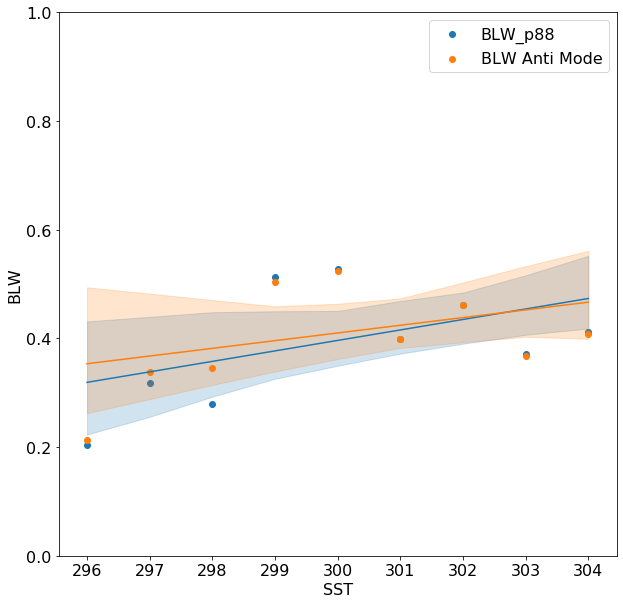

In [47]:
fig=plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})


x = np.arange(296,305)
y = np.zeros((100, 9))
m = np.zeros((100))

plt.scatter(x, BLW, label='BLW_p88', color='C0')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], BLW[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0), color='C0')
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())

print('BLW',np.mean(m))

plt.scatter(x, BLW_min, label='BLW Anti Mode', color='C1')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], BLW_min[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0), color='C1')
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())

print('BLW_min',np.mean(m))

plt.xlabel('SST')
plt.ylabel('BLW')
plt.ylim(0,1)
plt.legend()

plt.savefig('dSST_BLW_sclaing.pdf')

### CRH

In [ ]:
hist = np.zeros((9, 100))
edges = np.zeros((9,101))
mean_CRH = np.zeros(9)
mean_P = np.zeros(9)
BLW = np.zeros(9)
perc = np.zeros(9)
median=np.zeros(9)

for TTT in np.arange(296,305):
    i = TTT-296 #index
    print(TTT)
    
    #Open constants file
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
    const = xr.open_mfdataset(path+'output_3D/lfff00000000c.nc', combine='by_coords', )

    #Load 2D files
    d2D = pickle.load( open('pickles/output_'+str(TTT)+'.pkl', "rb" ) )
    d3D = pickle.load( open('pickles/output_3D_'+str(TTT)+'.pkl', "rb" ) )
                  
    qv_sat = mpcalc.saturation_mixing_ratio(d3D.P.isel(time=slice(4*85, None)), d3D.T.isel(time=slice(4*85, None))) * d3D.isel(time=slice(4*85, None)).P.differentiate("level") / mpconst.g  
    crh  = d2D.TQV.isel(time=slice(24*85, None, 6)) / qv_sat.sum(axis=1).mean(axis=0) 
    
    #Compute mean histogram
    h = np.zeros((crh.time.size, 100))
    e = np.zeros((crh.time.size, 101))
    for t in range(crh.time.size):
        density, e[t,:] = np.histogram(tqv.isel(time=t).values, density = True, bins = np.arange(0,1.01,0.01))
        h[t,:]  = density / density.sum()
    
    hist[i,:] = np.mean(h,axis=0)
    edges[i,:] = np.mean(e,axis=0)

    print(TTT, np.sum(hist))

    #Compute BLW
    for t in range(crh.time.size):
        BLW[i] = np.mean(calc_BLW(crh.isel(time=t).values))

   
    #Compute other indices
    mean_CRH[i] = crh.mean()
    perc[i]=np.percentile(crh, 88)
    median[i]=np.percentile(crh, 50)

   
#Save data
with open('pickles/CRH_dT_hist.pkl', 'wb') as pickle_file:
    pickle.dump(hist, pickle_file)
        
with open('pickles/CRH_dT_edges.pkl', 'wb') as pickle_file:
    pickle.dump(edges, pickle_file)
        
with open('pickles/CRH_dT_BLW.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
        
with open('pickles/CRH_dT_mean_CRH.pkl', 'wb') as pickle_file:
    pickle.dump(mean_CRH, pickle_file)
        
with open('pickles/CRH_dT_p88.pkl', 'wb') as pickle_file:
    pickle.dump(perc, pickle_file)
    
with open('pickles/CRH_dT_median.pkl', 'wb') as pickle_file:
    pickle.dump(median, pickle_file)

In [7]:
hist = np.zeros((9, 100))
edges = np.zeros((9,101))
mean_CRH = np.zeros(9)
mean_P = np.zeros(9)
BLW = np.zeros(9)
perc = np.zeros(9)
median=np.zeros(9)

for TTT in np.arange(296,305):
    i = TTT-296 #index
    hist[i] = pickle.load( open( 'pickles/CRH_dT_hist_'+str(TTT)+'.pkl', "rb" ) )
    edges[i] = pickle.load( open( 'pickles/CRH_dT_edges_'+str(TTT)+'.pkl', "rb" ) )
    BLW[i] = pickle.load( open( 'pickles/CRH_dT_BLW_'+str(TTT)+'.pkl', "rb" ) )
    perc[i] = pickle.load( open( 'pickles/CRH_dT_p88_'+str(TTT)+'.pkl', "rb" ) )
    median[i] = pickle.load( open( 'pickles/CRH_dT_median_'+str(TTT)+'.pkl', "rb" ) )

    #Save data
with open('pickles/CRH_dT_hist.pkl', 'wb') as pickle_file:
    pickle.dump(hist, pickle_file)
        
with open('pickles/CRH_dT_edges.pkl', 'wb') as pickle_file:
    pickle.dump(edges, pickle_file)
        
with open('pickles/CRH_dT_BLW.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
        
with open('pickles/CRH_dT_mean_CRH.pkl', 'wb') as pickle_file:
    pickle.dump(mean_CRH, pickle_file)
        
with open('pickles/CRH_dT_p88.pkl', 'wb') as pickle_file:
    pickle.dump(perc, pickle_file)
    
with open('pickles/CRH_dT_median.pkl', 'wb') as pickle_file:
    pickle.dump(median, pickle_file)

In [93]:
hist = pickle.load( open( 'pickles/CRH_dT_hist.pkl', "rb" ) )
edges = pickle.load( open( 'pickles/CRH_dT_edges.pkl', "rb" ) )
BLW = pickle.load( open( 'pickles/CRH_dT_BLW.pkl', "rb" ) )
mean_TQV = pickle.load( open( 'pickles/CRH_dT_mean_TQV.pkl', "rb" ) )                            
perc = pickle.load( open( 'pickles/CRH_dT_p88.pkl', "rb" ) )
median = pickle.load( open( 'pickles/CRH_dT_median.pkl', "rb" ) )

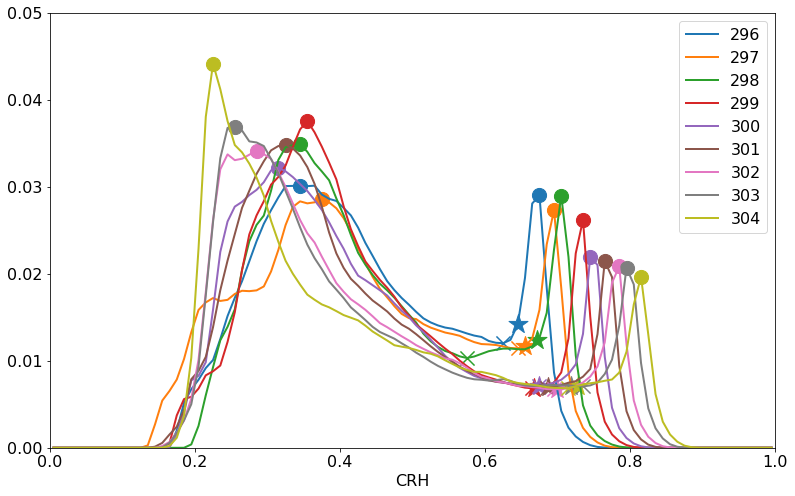

In [9]:
lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(13,8))
plt.rcParams.update({'font.size': 16})

for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:87], order=5)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(0,1)
plt.ylim(0,0.05)
plt.xlabel('CRH')
plt.legend()

plt.savefig('dSST_CRH_PDF.pdf')

# Upper Troposphere RH

In [74]:
d3D = pickle.load( open('pickles/output_3D_300.pkl', "rb" ) )
plevel=350
lvl_350 = (np.abs(d3D.P.isel(time=slice(4*85, None)).mean(axis=(0,2,3)).values / 100 - plevel)).argmin()
lvl_350

49

In [ ]:
hist = np.zeros((9, 100))
edges = np.zeros((9,101))
mean_RH = np.zeros(9)
mean_P = np.zeros(9)
BLW = np.zeros(9)
perc = np.zeros(9)
median=np.zeros(9)

lvl = 49 #350 hPa

for TTT in np.arange(296,305):
    i = TTT-296 #index
    
    print(TTT)
    
    d3D = pickle.load( open('pickles/output_3D_'+str(TTT)+'.pkl', "rb" ) )
    rh = d3D.RELHUM.isel(time=slice(4*85, None), level=lvl)
    
    #Compute mean histogram
    h = np.zeros((rh.time.size, 100))
    e = np.zeros((rh.time.size, 101))
    for t in range(rh.time.size):
        h[t,:], e[t,:] = np.histogram(rh.isel(time=t).values, density = True, bins = 100)
    
    hist[i,:] = np.mean(h,axis=0)
    edges[i,:] = np.mean(e,axis=0)

    #Compute BLW
    for t in range(rh.time.size):
        BLW[i] = np.mean(calc_BLW(rh.isel(time=t).values))
    
    #Compute other indices
    mean_RH[i] = rh.mean()
    perc[i]=np.percentile(rh, 88)
    median[i]=np.percentile(rh, 50)

    
#Save data
with open('pickles/dT_hist_350hPa.pkl', 'wb') as pickle_file:
    pickle.dump(hist, pickle_file)
        
with open('pickles/dT_edges_350hPa.pkl', 'wb') as pickle_file:
    pickle.dump(edges, pickle_file)
        
with open('pickles/dT_BLW_350hPa.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
        
with open('pickles/dT_mean_RH_350hPa.pkl', 'wb') as pickle_file:
    pickle.dump(mean_RH, pickle_file)
        
with open('pickles/dT_p88_350hPa.pkl', 'wb') as pickle_file:
    pickle.dump(perc, pickle_file)
    
with open('pickles/dT_median_350hPa.pkl', 'wb') as pickle_file:
    pickle.dump(median, pickle_file)

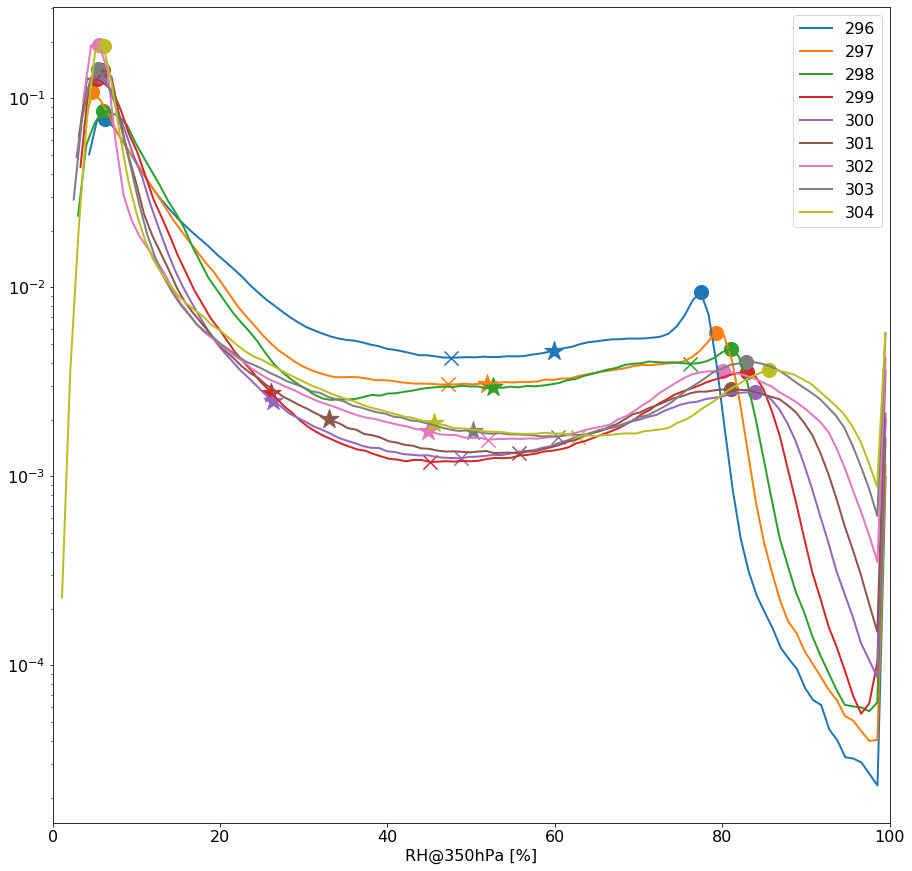

In [72]:
lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 16})

for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:87], order=5)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(0,100)
plt.yscale('log')
plt.xlabel('RH@350hPa [%]')
plt.legend()

#plt.savefig('dSST_CWV_PDF.pdf')

In [76]:
d3D = pickle.load( open('pickles/output_3D_300.pkl', "rb" ) )
plevel=500
lvl_500 = (np.abs(d3D.P.isel(time=slice(4*85, None)).mean(axis=(0,2,3)).values / 100 - plevel)).argmin()
lvl_500

55

In [77]:
hist = np.zeros((9, 100))
edges = np.zeros((9,101))
mean_RH = np.zeros(9)
mean_P = np.zeros(9)
BLW = np.zeros(9)
perc = np.zeros(9)
median=np.zeros(9)

lvl = 55 #500 hPa

for TTT in np.arange(296,305):
    i = TTT-296 #index
    
    print(TTT)
    
    d3D = pickle.load( open('pickles/output_3D_'+str(TTT)+'.pkl', "rb" ) )
    rh = d3D.RELHUM.isel(time=slice(4*85, None), level=lvl)
    
    #Compute mean histogram
    h = np.zeros((rh.time.size, 100))
    e = np.zeros((rh.time.size, 101))
    for t in range(rh.time.size):
        h[t,:], e[t,:] = np.histogram(rh.isel(time=t).values, density = True, bins = 100)
    
    hist[i,:] = np.mean(h,axis=0)
    edges[i,:] = np.mean(e,axis=0)

    #Compute BLW
    for t in range(rh.time.size):
        BLW[i] = np.mean(calc_BLW(rh.isel(time=t).values))
    
    #Compute other indices
    mean_RH[i] = rh.mean()
    perc[i]=np.percentile(rh, 88)
    median[i]=np.percentile(rh, 50)

    
#Save data
with open('pickles/dT_hist_500hPa.pkl', 'wb') as pickle_file:
    pickle.dump(hist, pickle_file)
        
with open('pickles/dT_edges_500hPa.pkl', 'wb') as pickle_file:
    pickle.dump(edges, pickle_file)
        
with open('pickles/dT_BLW_500hPa.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
        
with open('pickles/dT_mean_RH_500hPa.pkl', 'wb') as pickle_file:
    pickle.dump(mean_RH, pickle_file)
        
with open('pickles/dT_p88_500hPa.pkl', 'wb') as pickle_file:
    pickle.dump(perc, pickle_file)
    
with open('pickles/dT_median_500hPa.pkl', 'wb') as pickle_file:
    pickle.dump(median, pickle_file)

296
297
298
299
300
301
302
303
304


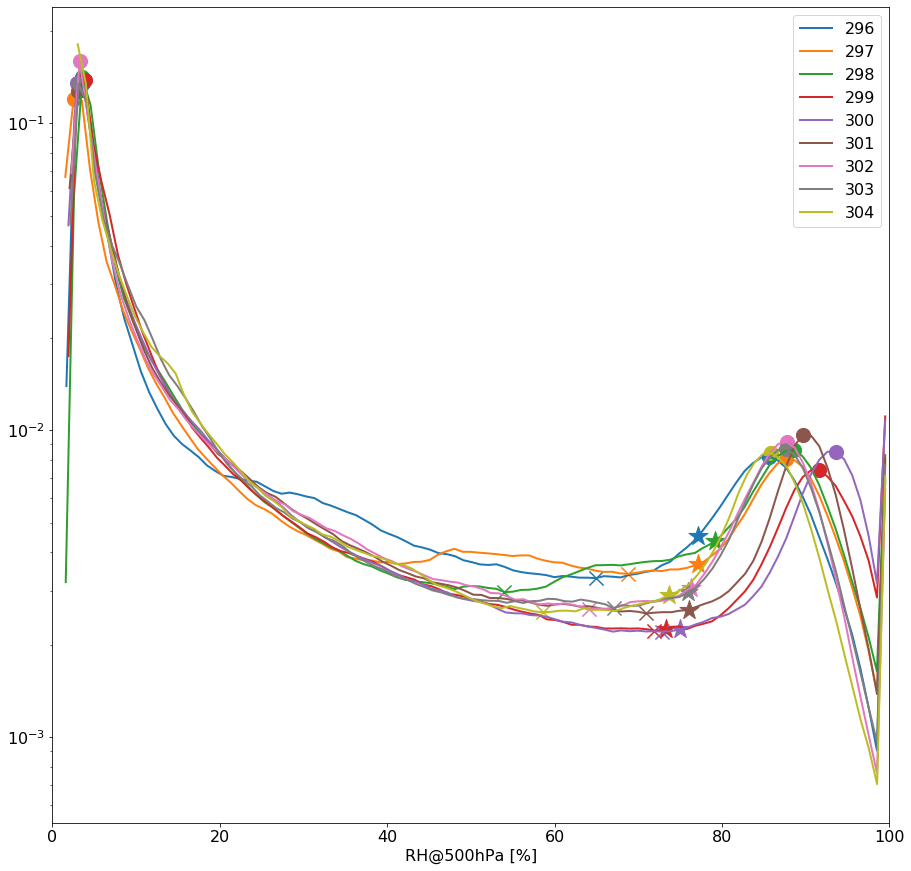

In [78]:
lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 16})

for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:87], order=5)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(0,100)
plt.yscale('log')
plt.xlabel('RH@500hPa [%]')
plt.legend()

#plt.savefig('dSST_CWV_PDF.pdf')

In [80]:
d3D = pickle.load( open('pickles/output_3D_300.pkl', "rb" ) )
plevel=900
lvl_900 = (np.abs(d3D.P.isel(time=slice(4*85, None)).mean(axis=(0,2,3)).values / 100 - plevel)).argmin()
lvl_900

67

In [82]:
hist = np.zeros((9, 100))
edges = np.zeros((9,101))
mean_RH = np.zeros(9)
mean_P = np.zeros(9)
BLW = np.zeros(9)
perc = np.zeros(9)
median=np.zeros(9)

lvl = 67 #900 hPa

for TTT in np.arange(296,305):
    i = TTT-296 #index
    
    print(TTT)
    
    d3D = pickle.load( open('pickles/output_3D_'+str(TTT)+'.pkl', "rb" ) )
    rh = d3D.RELHUM.isel(time=slice(4*85, None), level=lvl)
    
    #Compute mean histogram
    h = np.zeros((rh.time.size, 100))
    e = np.zeros((rh.time.size, 101))
    for t in range(rh.time.size):
        h[t,:], e[t,:] = np.histogram(rh.isel(time=t).values, density = True, bins = 100)
    
    hist[i,:] = np.mean(h,axis=0)
    edges[i,:] = np.mean(e,axis=0)

    #Compute BLW
    for t in range(rh.time.size):
        BLW[i] = np.mean(calc_BLW(rh.isel(time=t).values))
    
    #Compute other indices
    mean_RH[i] = rh.mean()
    perc[i]=np.percentile(rh, 88)
    median[i]=np.percentile(rh, 50)

    
#Save data
with open('pickles/dT_hist_900hPa.pkl', 'wb') as pickle_file:
    pickle.dump(hist, pickle_file)
        
with open('pickles/dT_edges_900hPa.pkl', 'wb') as pickle_file:
    pickle.dump(edges, pickle_file)
        
with open('pickles/dT_BLW_900hPa.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
        
with open('pickles/dT_mean_RH_900hPa.pkl', 'wb') as pickle_file:
    pickle.dump(mean_RH, pickle_file)
        
with open('pickles/dT_p88_900hPa.pkl', 'wb') as pickle_file:
    pickle.dump(perc, pickle_file)
    
with open('pickles/dT_median_900hPa.pkl', 'wb') as pickle_file:
    pickle.dump(median, pickle_file)

296
297
298
299
300
301
302
303
304


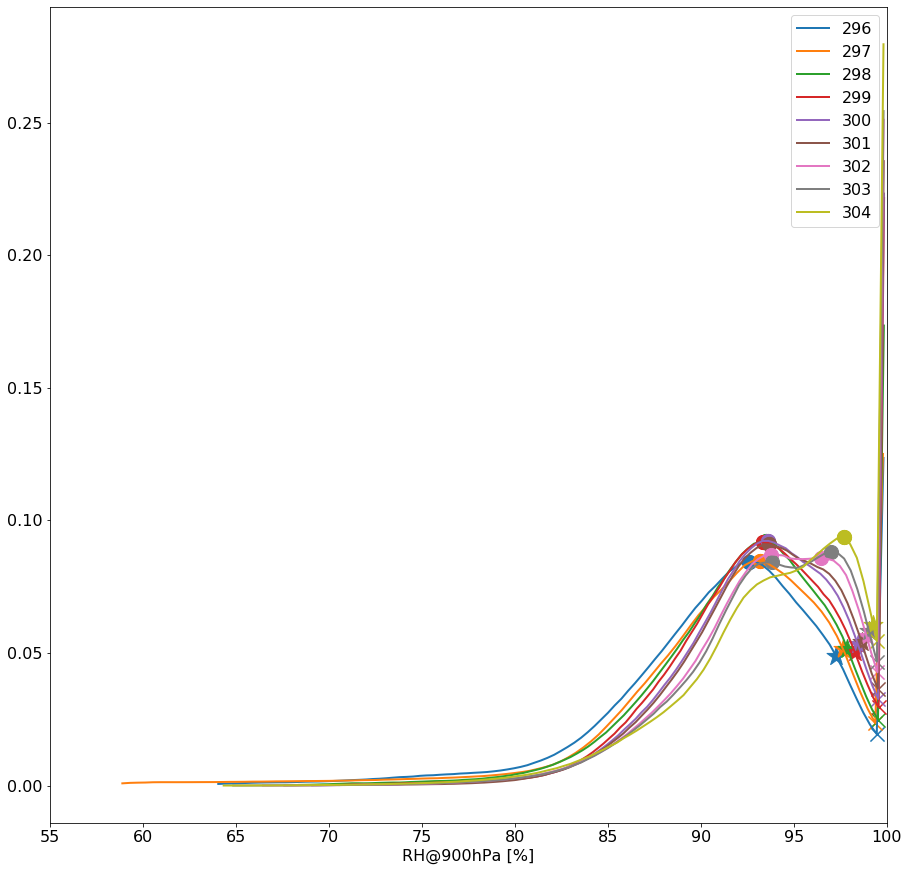

In [90]:
lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 16})

for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:], order=5)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(55,100)

plt.xlabel('RH@900hPa [%]')
plt.legend()

#plt.savefig('dSST_CWV_PDF.pdf')